In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import cv2

We need to create some data that isn't plates so that the CNN recognice if it's either catputing plates or not, and what exactly counts as a plate.

In [14]:
import pandas as pd
import json
import urllib
from PIL import Image
url='Indian_Number_plates.json'
data = pd.read_json('Indian_Number_plates.json', lines=True)
pd.set_option('display.max_colwidth', -1)
# Se borra la columna extra 
del data['extras']

# Se extraen los puntos con las cajas de la placa
data['points'] = data.apply(lambda row: row['annotation'][0]['points'], axis=1)

#se borra el resto de los datos
del data['annotation']
data.head()


IMG_SIZE=128


Images = []
training_data=[]

def imagesplitter(row,im,split,label):
        # Points of rectangle
        if label==0:
            
            x_point_top = row[1][0]['x']*im.shape[1]/split
            y_point_top = row[1][0]['y']*im.shape[0]/split
            x_point_bot = row[1][1]['x']*im.shape[1]/split
            y_point_bot = row[1][1]['y']*im.shape[0]/split

            # Cut the plate from the image and use it as output
            carImage = Image.fromarray(im)
            plateImage = carImage.crop((x_point_top, y_point_top, x_point_bot, y_point_bot))
        else:
            plateImage  = Image.fromarray(im)
        new_plateImage=plateImage.resize((IMG_SIZE,IMG_SIZE))
        training_data.append([new_plateImage, label])  # add this to our training_data
        
    
def downloadTraining(df):

    for index, row in df.iterrows():

        # Get the image from the URL
        resp = urllib.request.urlopen(row[0])
        im = np.array(Image.open(resp))
        # We append the image to the training input array
        Images.append(im)  
        imagesplitter(row,im,1,0) #add plate
        imagesplitter(row,im,2,1) #add somthing that isnt a plate

downloadTraining(data)


Let's see some data 

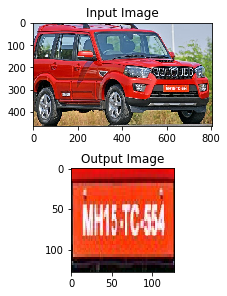

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots(2, 1, constrained_layout=True)

# Set title
ax[0].set_title('Input Image')
ax[1].set_title('Output Image')

# Display the images
ax[0].imshow(Images[0])
ax[1].imshow(training_data[0][0])

plt.show()

In [17]:
#this is the amount of data we have
len(training_data)

474

We pass this to a format that would be received to our model conv layer

In [18]:
import random
import pickle
random.shuffle(training_data)
Features_output = []
Labels_output = []
for features,label in training_data:
    try:
        opencvImage = cv2.cvtColor(np.array(features), cv2.COLOR_RGB2BGR)    
        Features_output.append(opencvImage)
        Labels_output.append(label)
    except:
        print("Image input error, do not add to the format output") 



Features_output = np.array(Features_output).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

#we proceed to save the output 

pickle_out = open("Features_output.pickle","wb")
pickle.dump(Features_output, pickle_out)
pickle_out.close()

pickle_out = open("Labels_output.pickle","wb")
pickle.dump(Labels_output, pickle_out)
pickle_out.close()

Image input error, do not add to the format output
Image input error, do not add to the format output


Lets start with some training

In [19]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import pickle

pickle_in = open("Features_output.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("Labels_output.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y, batch_size=24, epochs=10, validation_split=0.3)

Train on 330 samples, validate on 142 samples
Epoch 1/10
330/330 [==============================] - 36s 110ms/sample - loss: 6.4468 - acc: 0.5242 - val_loss: 0.6611 - val_acc: 0.5141
Epoch 2/10
330/330 [==============================] - 32s 98ms/sample - loss: 0.5300 - acc: 0.7455 - val_loss: 0.5111 - val_acc: 0.7113
Epoch 3/10
330/330 [==============================] - 26s 78ms/sample - loss: 0.3446 - acc: 0.8606 - val_loss: 0.3590 - val_acc: 0.8451
Epoch 4/10
330/330 [==============================] - 26s 80ms/sample - loss: 0.2005 - acc: 0.9182 - val_loss: 0.6362 - val_acc: 0.6972
Epoch 5/10
330/330 [==============================] - 26s 79ms/sample - loss: 0.2004 - acc: 0.9333 - val_loss: 0.3444 - val_acc: 0.8803
Epoch 6/10
330/330 [==============================] - 27s 81ms/sample - loss: 0.1073 - acc: 0.9697 - val_loss: 0.2474 - val_acc: 0.9577
Epoch 7/10
330/330 [==============================] - 28s 85ms/sample - loss: 0.0596 - acc: 0.9727 - val_loss: 0.3238 - val_acc: 0.9014
E

Lets use our model with some new examples

(530, 795, 3)


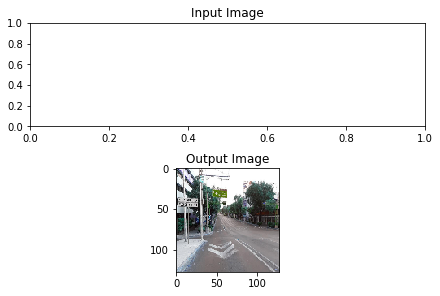

(512, 669, 3)


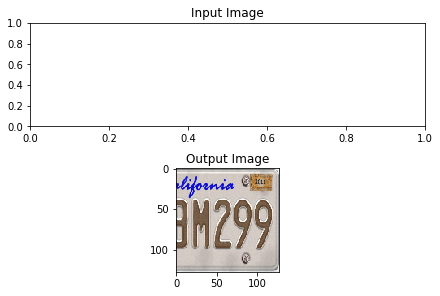

(216, 435, 3)


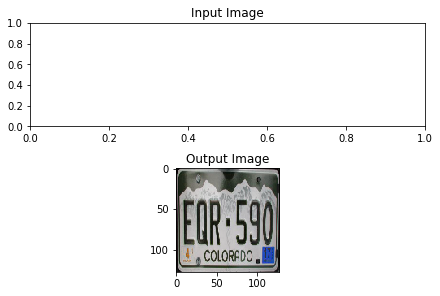

(852, 871, 3)


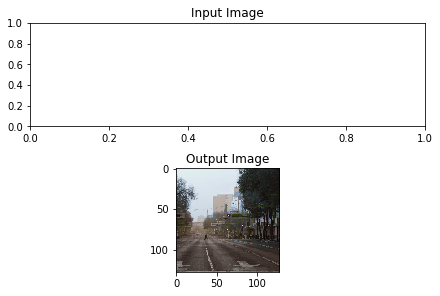

(530, 784, 3)


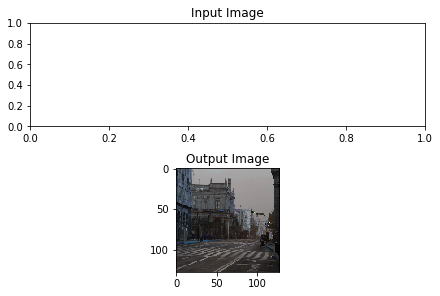

(524, 474, 3)


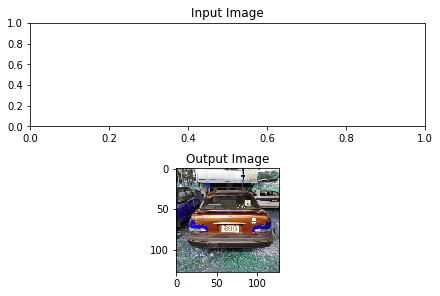

(960, 540, 3)


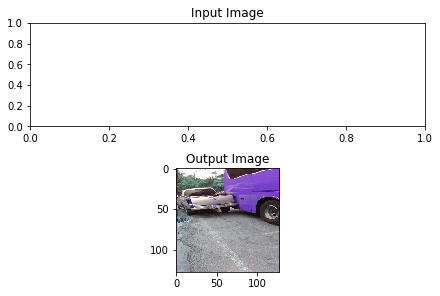

(183, 275, 3)


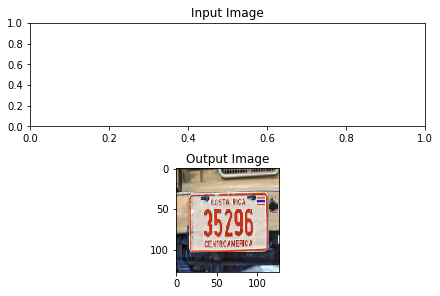

(169, 225, 3)


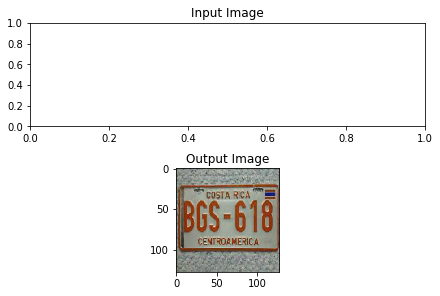

[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]


In [28]:
IMG_SIZE = 128 
def prepare(filepath):
    im = np.array(Image.open(filepath))
    print(im.shape)
    opencvImage = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)    
    new_array = cv2.resize(opencvImage, (IMG_SIZE, IMG_SIZE))
    
    fig, ax = plt.subplots(2, 1, constrained_layout=True)

    # Set title
    ax[0].set_title('Input Image')
    ax[1].set_title('Output Image')

    # Display the images
    ax[1].imshow(new_array)

    plt.show()
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)


prediction = model.predict([prepare('/home/alejandro/placas/prueba1.jpg')])
prediction2 = model.predict([prepare('/home/alejandro/placas/prueba2.jpg')])
prediction3 = model.predict([prepare('/home/alejandro/placas/prueba3.jpg')])
prediction4 = model.predict([prepare('/home/alejandro/placas/prueba4.jpg')])
prediction5 = model.predict([prepare('/home/alejandro/placas/prueba5.jpg')])
prediction6 = model.predict([prepare('/home/alejandro/placas/prueba6.jpg')])
prediction7 = model.predict([prepare('/home/alejandro/placas/prueba7.jpg')])
prediction8 = model.predict([prepare('/home/alejandro/placas/prueba8.jpg')])
prediction9 = model.predict([prepare('/home/alejandro/placas/prueba9.jpg')])


print(prediction)
print(prediction2)
print(prediction3)
print(prediction4)
print(prediction5)
print(prediction6)
print(prediction7)
print(prediction8)
print(prediction9)

Seems our model has trouble if it captures half plates, all the other test seemed to provide good results